# Simple regression with bayesian neural networks

In this notebook you will find a comparison between two bayesian methods to assess uncertainty when dealing with neural networks: **Monte-Carlo Dropout** (["Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning"](https://arxiv.org/abs/1506.02142)) and **Bayesian by Backpropagation** (["Weight Uncertainty in Neural Networks"](https://arxiv.org/abs/1505.05424)). We study a very simple toy regression model in 1D.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats, clear_output
set_matplotlib_formats('retina')
plt.style.use('ggplot')

import torch
from torch.utils import data

## 0. Data preparation

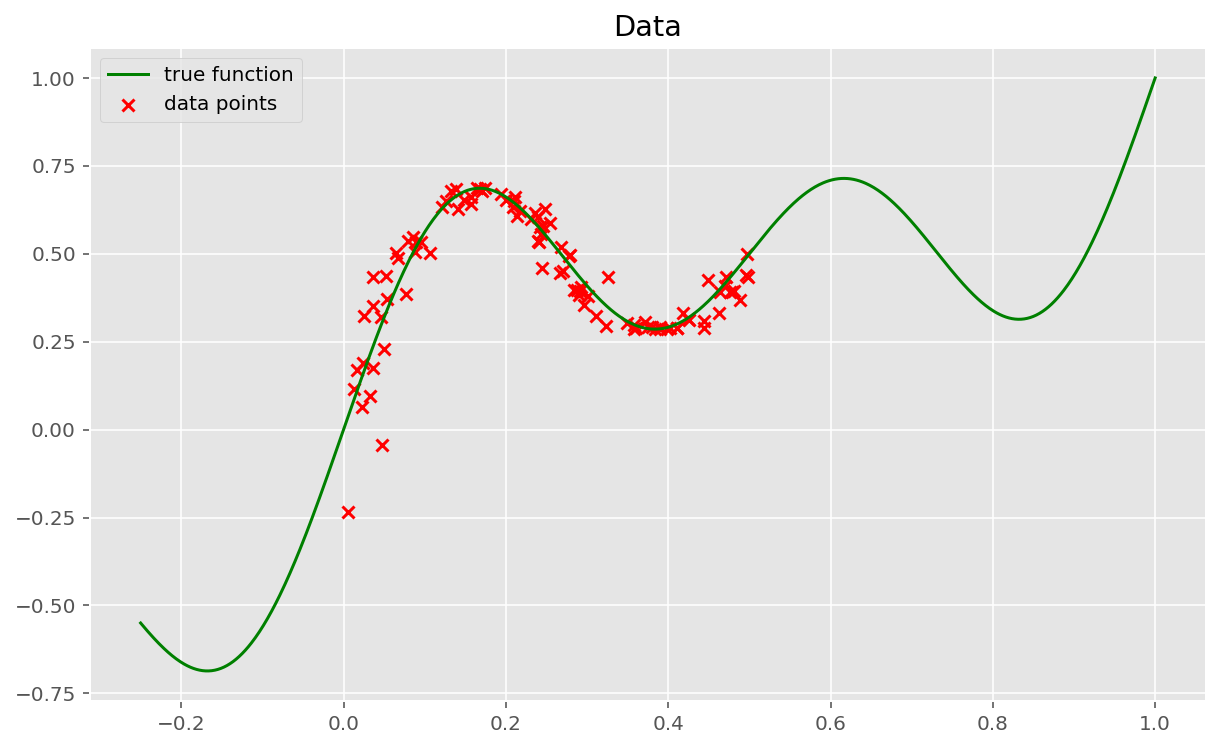

In [2]:
N = 100  #number of training data points
sigma = 0.02
dataset = {}

def function(x, epsilon):
    return x + 0.3 * np.sin(2 * np.pi * (x + epsilon)) + 0.3 * np.sin(4 * np.pi * (x + epsilon)) + epsilon

dataset['X_train'] = np.random.uniform(0, 0.5, N)
dataset['y_train'] = function(dataset['X_train'], np.random.normal(0, sigma, N))

dataset['X_test'] = np.linspace(-0.25, 1, 1000)
F = function(dataset['X_test'], 0)

plt.figure(figsize=(10, 6))
plt.plot(dataset['X_test'], F, color='green', label='true function')
plt.scatter(dataset['X_train'], dataset['y_train'], marker='x', color='red', label='data points')
plt.legend()
plt.title("Data")
plt.show()

In [3]:
X_train_tensor = torch.from_numpy(dataset['X_train'].copy()).float().unsqueeze(dim=1)
y_train_tensor = torch.from_numpy(dataset['y_train'].copy()).float()
X_test_tensor = torch.from_numpy(dataset['X_test'].copy()).float().unsqueeze(dim=1)

## 1. Deterministic regression

In [105]:
import models.deterministic_regression as dreg

##### Definition of the model

In [106]:
net = dreg.DeterministicNet(hidden_size=100, dim_input=1, dim_output=1)
reg_model = dreg.DeterministicReg(X_train_tensor, y_train_tensor, X_test_tensor, net)

##### Training step

In [107]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-6)
reg_model.train(5000, optimizer, criterion, batch=False)

##### Test step

In [108]:
y_pred = reg_model.predict()

##### Plot results

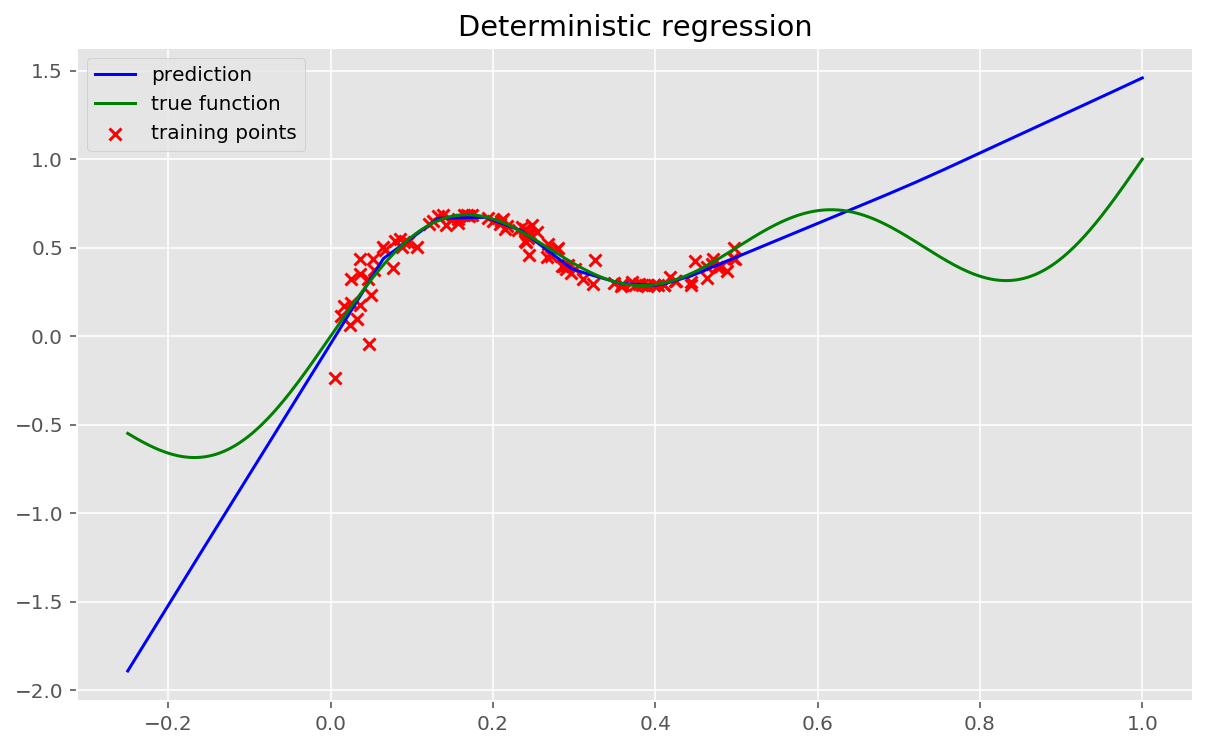

In [109]:
plt.figure(figsize=(10, 6))
reg_model.plot_results()
plt.plot(dataset['X_test'], F, color='green', label='true function')
plt.legend()
plt.title('Deterministic regression')
plt.show()

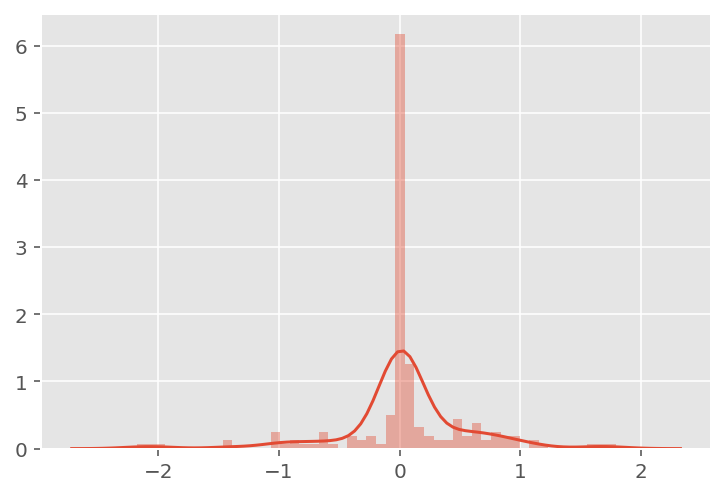

In [110]:
sns.distplot(net.weights_dist())

## 2. Bayesian regression with Monte-Carlo dropout

In [360]:
import models.dropout_regression as doreg

##### Definition of the model

In [361]:
net = doreg.DropoutNet(hidden_size=100, dim_input=1, dim_output=1, p=0.25)
reg_model = doreg.DropoutReg(X_train_tensor, y_train_tensor, X_test_tensor, net, batch_size=X_train_tensor.shape[0])

##### Training step

In [362]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-6)
reg_model.train(5000, optimizer, criterion)

##### Test step

In [363]:
y_pred_mean, y_pred_std = reg_model.predict(samples=1000)

##### Plot results

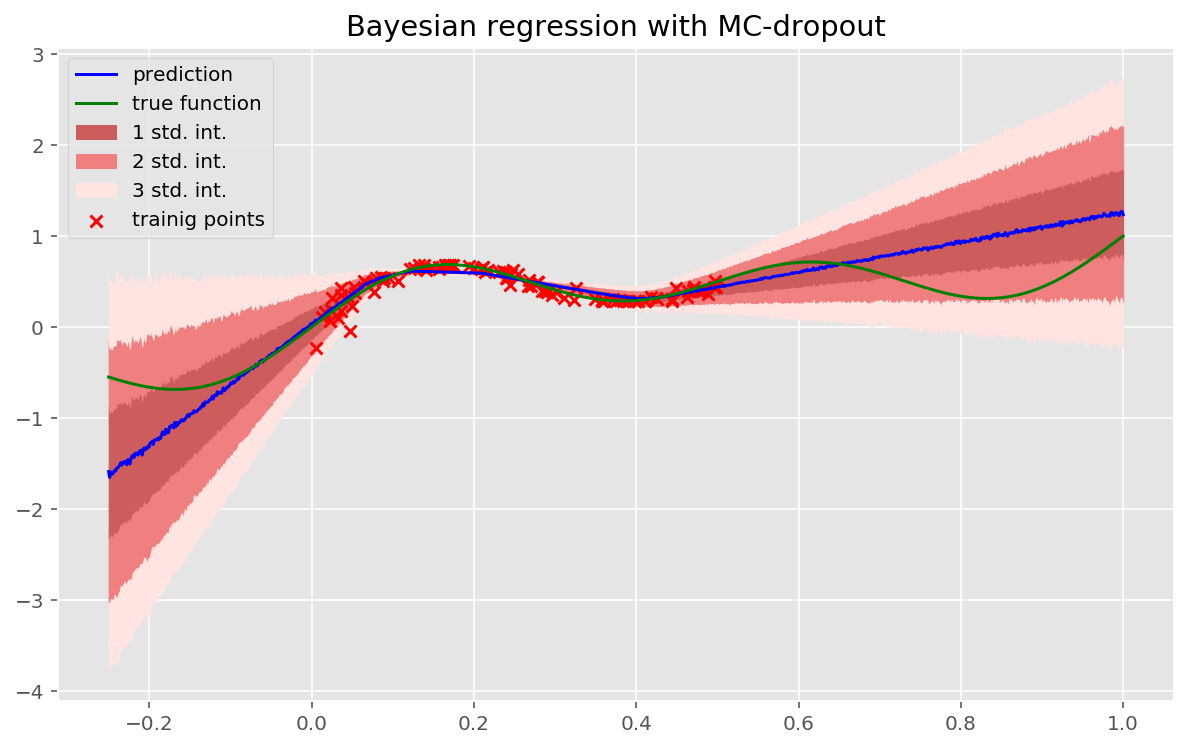

In [364]:
plt.figure(figsize=(10, 6))
reg_model.plot_results()
plt.plot(dataset['X_test'], F, color='green', label='true function')
plt.legend()
plt.title("Bayesian regression with MC-dropout")
plt.show()

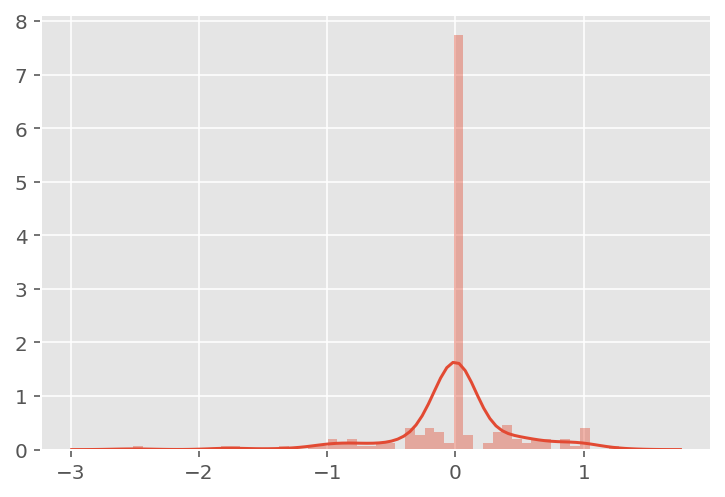

In [365]:
sns.distplot(net.weights_dist())
plt.show()

In [355]:
def log_likelihood(y, output, sigma=sigma):
    return torch.sum(-0.5 * np.log(2 * np.pi * sigma ** 2) - 0.5 * (y.squeeze() - output.squeeze()) ** 2 / sigma ** 2)

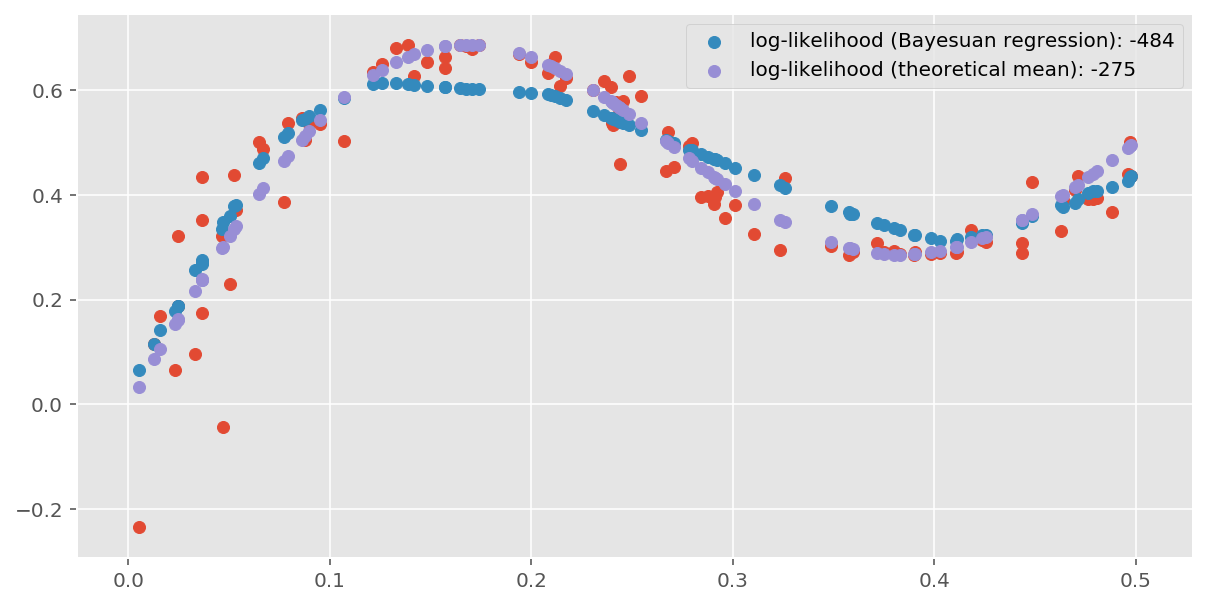

In [369]:
y = torch.zeros_like(net(reg_model.X_train))
for i in range(1000):
    y += net(reg_model.X_train) / 1000

plt.figure(figsize=(10, 5))
plt.scatter(reg_model.X_train, reg_model.y_train)
plt.scatter(reg_model.X_train, y.detach(), label=f'log-likelihood (Bayesuan regression): {log_likelihood(reg_model.y_train, y):.0f}')
plt.scatter(reg_model.X_train, function(reg_model.X_train, 0), label=f'log-likelihood (theoretical mean): {log_likelihood(reg_model.y_train, function(reg_model.X_train, 0)):.0f}')
plt.legend()
plt.show()

## 3. Bayesian regression with Bayesian by Backpropagation

In [334]:
import models.bayesbackprop_regression as bbb

##### Definition of the model

In [335]:
prior_parameters = {'sigma1': 1, 'sigma2': np.exp(-6), 'pi': 0.5}
net = bbb.BayesBackpropNet(hidden_size=100, dim_input=1, dim_output=1, prior_parameters=prior_parameters, sigma=0.02)
reg_model = bbb.BayesBackpropReg(X_train_tensor, y_train_tensor, X_test_tensor, net, batch_size=10)

##### Training step

In [345]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-6)
reg_model.train(2000, optimizer, 2)

   0: 332.792969
  50: 235.305115
 100: 244.038116
 150: 589.767273
 200: 149.648956
 250: 145.517487
 300: 332.726593
 350: 112.371109
 400: 216.887192
 450: 316.846497
 500: 265.855103
 550: 110.950668
 600: 200.103073
 650: 135.596924
 700: 218.127487
 750: 181.892029
 800: 135.443253
 850: 173.623611
 900: 159.177582
 950: 112.876396
1000: 148.206116
1050: 111.033539
1100: 162.947266
1150: 122.383072
1200: 131.444824
1250: 113.532288
1300: 130.339294
1350: 100.532349
1400: 107.485168
1450: 158.358780
1500: 101.835693
1550: 98.236618
1600: 94.978493
1650: 99.437988
1700: 112.800583
1750: 139.241791
1800: 112.876930
1850: 126.578789
1900: 124.083954
1950: 85.730881


##### Test step

In [346]:
y_pred_mean, y_pred_std = reg_model.predict(samples=1000)

##### Plot results

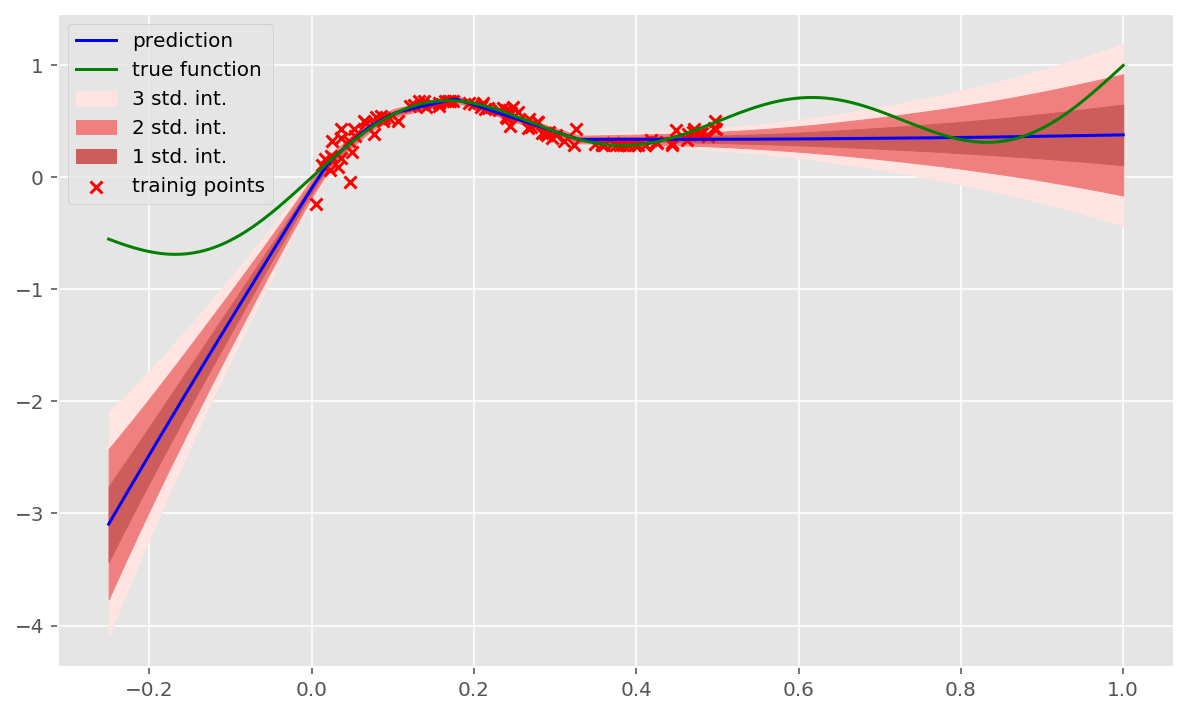

In [347]:
plt.figure(figsize=(10, 6))
reg_model.plot_results()
plt.plot(dataset['X_test'], F, color='green', label='true function')
plt.legend()
plt.show()

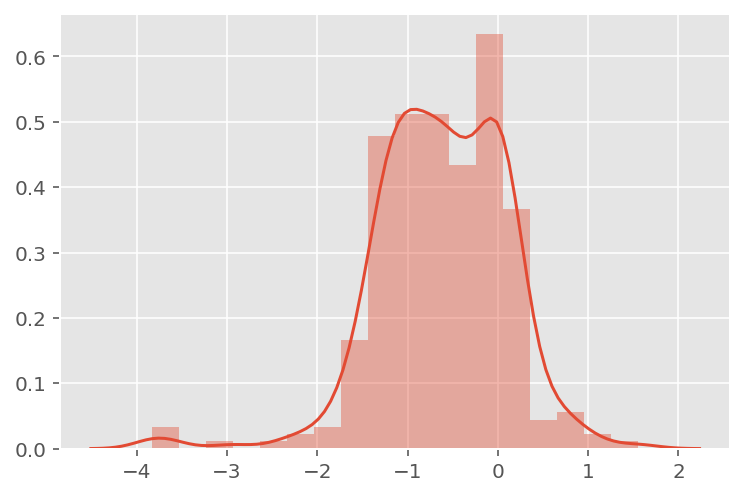

In [348]:
sns.distplot(net.weights_dist())

In [349]:
net.log_likelihood(reg_model.y_train, net(reg_model.X_train).squeeze())

tensor(-422.9891, grad_fn=<SumBackward0>)

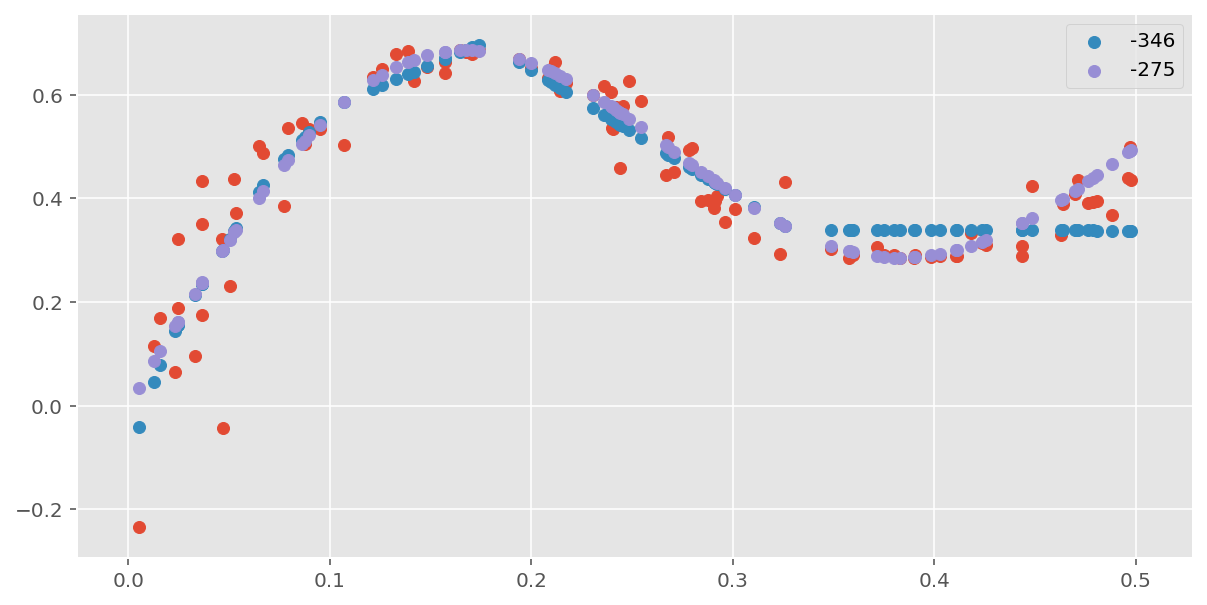

In [359]:
y = torch.zeros_like(net(reg_model.X_train))
for i in range(100):
    y += net(reg_model.X_train) / 100

plt.figure(figsize=(10, 5))
plt.scatter(reg_model.X_train, reg_model.y_train)
plt.scatter(reg_model.X_train, y.detach(), label=f'{log_likelihood(reg_model.y_train, y):.0f}')
plt.scatter(reg_model.X_train, function(reg_model.X_train, 0), label=f'{log_likelihood(reg_model.y_train, function(reg_model.X_train, 0)):.0f}')
plt.legend()
plt.show()